In [1]:
import sys
sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2
%aimport std_func

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

## Estimates from Factor Model
We assume a factor model where there are $k$ assets and $T$ time periods (months in our case), m is the common factors (topic weights in our case). $r_{it}$ is the return for asset $i$ at time $t$.

$$
\begin{align}
r_{it}
= &\alpha_i + \sum_{j=1}^{m} \beta_{ij} f_jt + \epsilon_{it}, t = 1, \dots, T, i = 1, \dots, k\\ \\
R_{k \times T} = & B_{k \times m} \cdot coef_{m \times T} + E_{k \times T}
\end{align}
$$

In our analysis, $R_{k \times T}$ is the returns matrix imported, $B_{k \times m}$ is the topic modeling matrix, and $coef_{m \times T}$ is the coefficient matrix computed from the linear regression of returns matrix on topic modeling matrix. $E_{k \times T}$ is the residual matrix.

In our factor model, 

$$\text{Cov}(r) = B \Sigma_{coef} B^T + D, 
\text{ where } D = diag(\sigma^2_1, \dots, \sigma^2_k) \text{ and Var}(\epsilon_i) = \sigma^2_i$$

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
import string
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [3]:
r_selected = pd.read_csv("data/filtered_r.csv")
# get the mean of all 
r_selected.set_index("name", inplace = True)
mu = r_selected.mean(axis = 1)
# compute the covariance matrix 
cov = r_selected.T.cov()

In [4]:
df = pd.read_csv('../data/preprocessed.csv',
                 usecols = ['reportingDate', 'name', 'CIK', 'coDescription',
                           'coDescription_stopwords', 'SIC', 'SIC_desc'])
df = df.set_index(df.name)

### Sent-LDA
We ran the coherence score benchmarking over a range of 3 to 40 topics, incrementing by 3. 

First, we fit the LDA model to all business description using the number of topics selected from coherence score benchmarking. 

Then, we assume each sentence only represents one topic; get the frequency of the topics revealed in the whole document (business description for one company) and calculate the probability of each topics in the whole document. 

#### Coherence Score Plot

![Factor_Model_Coherence_Score.png](images/Factor_Model_Coherence_Score.png)

Based on the above Coherence Score, we choose up to 12 topics since it gives the highest score up to here.

In [5]:
data = df.loc[:,"coDescription_stopwords"].to_list()

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.85, min_df=2, max_features=600)
tf = tf_vectorizer.fit_transform(data)
tf_feature_names = tf_vectorizer.get_feature_names_out()
lda = LatentDirichletAllocation(n_components=12, random_state=0).fit(tf)

We show the top 10 words by weights in the 12 topics LDA model generates in the below table.

In [7]:
std_func.get_topics(lda, tf_vectorizer, 12)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12
0,could,loan,share,product,investment,gas,hotel,patient,bank,customer,million,cell
1,gas,mortgage,stock,drug,income,oil,facility,treatment,capital,service,tax,cancer
2,regulation,real,note,fda,asset,natural,tenant,trial,institution,data,asset,tumor
3,oil,estate,issued,clinical,reit,production,lease,study,federal,product,net,product
4,future,commercial,preferred,patent,real,reserve,operating,phase,act,solution,income,therapy
5,natural,bank,date,approval,tax,proved,estate,clinical,banking,software,cash,therapeutic
6,price,interest,amount,trial,share,drilling,million,disease,holding,platform,expense,clinical
7,affect,rate,september,application,interest,regulation,real,drug,regulation,technology,value,technology
8,ability,million,per,regulatory,distribution,net,center,therapy,deposit,application,note,research
9,adversely,security,director,candidate,estate,water,portfolio,data,asset,sale,statement,license


#### Frequency of the Topics in Each Sentence

In [8]:
n_components = 12
prob = pd.DataFrame(0, index = df.name, columns = range(n_components))

In [9]:
for j in range(len(df)):
    LIST_sent = pd.Series(df.coDescription[j].split('.')).apply(std_func.lemmatize_sentence).apply(std_func.remove_nums).apply(std_func.remove_stopwords)
    
    X = tf_vectorizer.transform(LIST_sent.tolist())
    sent = lda.transform(X)
    sent_df = pd.DataFrame(sent)
    # drop the values that are smaller than 1/12
    # if the maximum value is 1/12, the probability of each topic in that sentence is the same
    # we cannot determine which topic to choose
    sent_df = sent_df[sent_df.max(axis = 1) > 1/12].reset_index(drop = True)

    for i in range(n_components):
        prob.iloc[j][i] = list(sent_df.idxmax(axis = 1)).count(i)
    
    # calculate the probability
    prob = prob.div(prob.sum(axis=1), axis=0)

In [10]:
prob

,0,1,2,3,4,5,6,7,8,9,10,11
name,,,,,,,,,,,,
"MONGODB, INC.",0.014652,0.007326,0.021978,0.036630,0.018315,0.010989,0.040293,0.021978,0.014652,0.739927,0.047619,0.025641
SALESFORCE COM INC,0.010811,0.010811,0.005405,0.016216,0.000000,0.021622,0.037838,0.005405,0.005405,0.821622,0.054054,0.010811
SPLUNK INC,0.010274,0.003425,0.013699,0.020548,0.013699,0.003425,0.023973,0.000000,0.003425,0.839041,0.058219,0.010274
"OKTA, INC.",0.020305,0.000000,0.015228,0.050761,0.015228,0.005076,0.040609,0.000000,0.015228,0.786802,0.030457,0.020305
VEEVA SYSTEMS INC,0.093245,0.012845,0.094196,0.028544,0.035205,0.008563,0.019981,0.010466,0.017602,0.315414,0.352046,0.011893
...,...,...,...,...,...,...,...,...,...,...,...,...
"AMERICAN REALTY CAPITAL NEW YORK CITY REIT, INC.",0.075472,0.084906,0.122642,0.009434,0.471698,0.009434,0.075472,0.000000,0.000000,0.066038,0.084906,0.000000
"CYCLACEL PHARMACEUTICALS, INC.",0.027460,0.000000,0.029748,0.272311,0.011442,0.009153,0.018307,0.308924,0.000000,0.029748,0.013730,0.279176
ZOETIS INC.,0.036519,0.018868,0.074254,0.033475,0.034084,0.013999,0.035301,0.018868,0.020694,0.053561,0.644553,0.015825


#### Demonstration in Pharmaceutical Preparations Industry

In [11]:
# get the names of the companies in the pharmaceutical preparations industry
Pharm = df[df.SIC == 2834]
Pharm_list = Pharm.index

In [12]:
# get the companies name that match return data and business description data
SET = (set(Pharm_list) & set(r_selected.index))
LIST = [*SET, ]

In [13]:
B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

##### Topic Matrix

In [14]:
B_matrix

,0,1,2,3,4,5,6,7,8,9,10,11
name,,,,,,,,,,,,
MARINUS PHARMACEUTICALS INC,0.044118,0.029412,0.000000,0.073529,0.000000,0.000000,0.000000,0.779412,0.000000,0.044118,0.014706,0.014706
"INTRA-CELLULAR THERAPIES, INC.",0.060484,0.004032,0.016129,0.048387,0.004032,0.004032,0.020161,0.677419,0.024194,0.060484,0.024194,0.056452
XENCOR INC,0.000000,0.000000,0.593103,0.158621,0.006897,0.062069,0.013793,0.055172,0.013793,0.020690,0.034483,0.041379
LIGAND PHARMACEUTICALS INC,0.007143,0.007143,0.035714,0.135714,0.028571,0.007143,0.035714,0.285714,0.007143,0.092857,0.035714,0.321429
PROTHENA CORP PLC,0.014085,0.000000,0.028169,0.042254,0.000000,0.000000,0.014085,0.478873,0.000000,0.056338,0.014085,0.352113
...,...,...,...,...,...,...,...,...,...,...,...,...
CATABASIS PHARMACEUTICALS INC,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.807692,0.000000,0.038462,0.000000,0.076923
OPHTHOTECH CORP.,0.014823,0.006842,0.026226,0.367161,0.014823,0.007982,0.015964,0.294185,0.009122,0.044470,0.011403,0.187001
"IMPRIMIS PHARMACEUTICALS, INC.",0.000000,0.000000,0.106509,0.349112,0.011834,0.017751,0.029586,0.142012,0.017751,0.106509,0.088757,0.130178


In [15]:
r_Pharm = r_selected.T[LIST].T

In [16]:
coef_mat = pd.DataFrame(0, index = r_Pharm.columns, columns = range(n_components))

In [17]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression()

In [18]:
for i in range(len(r_Pharm.columns)):
    date = r_Pharm.columns[i]
    r_t_i = r_Pharm[date] 
    reg = LR.fit(B_matrix, r_t_i)
    coef_mat.iloc[i] = reg.coef_

##### Coefficient Matrix

In [19]:
coef_mat

,0,1,2,3,4,5,6,7,8,9,10,11
2016-06-30,0.993361,-1.875375,0.195258,-0.337758,1.312631,2.051489,1.238693,-0.392438,-2.489539,-0.470602,-0.236897,0.011175
2016-07-31,-0.587373,2.486985,-0.051766,-0.119139,0.599033,-0.509589,0.034452,-0.130789,-1.116928,-0.347125,0.009258,-0.267018
2016-08-31,-0.088389,-2.184883,0.309753,0.127562,0.202514,-0.612011,-1.106752,0.233257,1.801470,0.803841,0.164920,0.348719
2016-09-30,-0.122107,1.875134,0.171593,0.108377,0.836037,-0.015983,-1.795211,-0.121855,-0.571359,-0.409085,0.001294,0.043164
2016-10-31,-0.236524,-2.536547,-0.143964,-0.035811,-0.187329,1.460662,-0.469362,-0.034221,1.959008,0.200099,0.077996,-0.054007
2016-11-30,-1.151701,1.936744,0.147886,-0.116144,0.417320,-1.095169,-1.533299,-0.054423,1.213919,-0.113511,0.200694,0.147685
2016-12-31,0.483848,-1.161150,-0.100632,-0.193967,-0.265334,0.825843,0.407563,-0.141296,1.436270,-0.580140,-0.186887,-0.524118
2017-01-31,-0.277906,1.977522,0.574171,0.256089,-1.584684,-3.236387,0.679985,0.346124,1.308807,-0.275143,0.050787,0.180636
2017-02-28,0.895630,3.177223,0.208617,-0.125386,-3.827412,-2.817838,0.297242,0.148517,2.594685,-0.329282,-0.044365,-0.177630
2017-03-31,-1.031747,1.838094,0.056902,-0.172604,-0.423448,-1.919721,-0.909357,-0.001361,3.564327,-0.665482,-0.290407,-0.045196


In [20]:
prediction = B_matrix.dot(coef_mat.T)
residual = r_Pharm - prediction

### Perform Mean-Variance Analysis
We only use the Pharmaceutical Preparations industry data to generate portfolio based on Mean-Variance Analysis.

In [21]:
!pip install PyPortfolioOpt

In [22]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
from pypfopt import plotting

#### Mean for Returns in the Pharmaceutical Preparations Industry

In [23]:
mu_Pharm = mu[LIST]
mu_Pharm

name
MARINUS PHARMACEUTICALS INC       0.044790
INTRA-CELLULAR THERAPIES, INC.   -0.012532
XENCOR INC                        0.040986
LIGAND PHARMACEUTICALS INC        0.012248
PROTHENA CORP PLC                -0.022615
                                    ...   
CATABASIS PHARMACEUTICALS INC    -0.043794
OPHTHOTECH CORP.                 -0.076591
IMPRIMIS PHARMACEUTICALS, INC.    0.031240
HERON THERAPEUTICS, INC. /DE/     0.013116
KARYOPHARM THERAPEUTICS INC.      0.017979
Length: 124, dtype: float64

#### Covariance Estimated
$$\text{Cov}(r) = B \Sigma_{coef} B^T + D, 
\text{ where } D = diag(\sigma^2_1, \dots, \sigma^2_k)$$

In [24]:
cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + np.diag(np.diag(residual.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index
cov_Factor_Model

name,MARINUS PHARMACEUTICALS INC,"INTRA-CELLULAR THERAPIES, INC.",XENCOR INC,LIGAND PHARMACEUTICALS INC,PROTHENA CORP PLC,BIOMARIN PHARMACEUTICAL INC,ACADIA PHARMACEUTICALS INC,FIBROGEN INC,SYNDAX PHARMACEUTICALS INC,XOMA CORP,...,"ZYNERBA PHARMACEUTICALS, INC.","ACTINIUM PHARMACEUTICALS, INC.","MERCK & CO., INC.",BIODELIVERY SCIENCES INTERNATIONAL INC,"BELLEROPHON THERAPEUTICS, INC.",CATABASIS PHARMACEUTICALS INC,OPHTHOTECH CORP.,"IMPRIMIS PHARMACEUTICALS, INC.","HERON THERAPEUTICS, INC. /DE/",KARYOPHARM THERAPEUTICS INC.
name,,,,,,,,,,,,,,,,,,,,,
MARINUS PHARMACEUTICALS INC,0.120925,0.030277,0.016047,0.020778,0.026992,0.025648,0.027218,0.020611,0.023519,0.016363,...,0.029832,0.028220,0.022374,0.022386,0.026656,0.034025,0.024983,0.023414,0.026228,0.023578
"INTRA-CELLULAR THERAPIES, INC.",0.030277,0.099772,0.020181,0.021970,0.028062,0.026028,0.027962,0.021614,0.024590,0.014437,...,0.030114,0.028619,0.024317,0.022813,0.027781,0.033172,0.025531,0.025355,0.025500,0.024538
XENCOR INC,0.016047,0.020181,0.056906,0.020317,0.022645,0.021435,0.021381,0.020641,0.021438,0.013405,...,0.021261,0.022073,0.020309,0.020103,0.018795,0.022688,0.021416,0.023823,0.017833,0.021089
LIGAND PHARMACEUTICALS INC,0.020778,0.021970,0.020317,0.052592,0.026961,0.022603,0.023013,0.021772,0.023103,0.016250,...,0.023534,0.026641,0.021593,0.022495,0.019002,0.026684,0.024103,0.025451,0.020740,0.024992
PROTHENA CORP PLC,0.026992,0.028062,0.022645,0.026961,0.100441,0.026106,0.027165,0.024097,0.026301,0.018032,...,0.028909,0.030927,0.024899,0.024968,0.024844,0.032275,0.027388,0.028084,0.025321,0.028406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CATABASIS PHARMACEUTICALS INC,0.034025,0.033172,0.022688,0.026684,0.032275,0.029566,0.031036,0.026350,0.028184,0.018314,...,0.033017,0.033222,0.026833,0.026959,0.028175,0.106089,0.029757,0.029756,0.029618,0.029110
OPHTHOTECH CORP.,0.024983,0.025531,0.021416,0.024103,0.027388,0.025293,0.025794,0.022484,0.024595,0.016374,...,0.026382,0.027606,0.023336,0.023528,0.022254,0.029757,0.088835,0.026240,0.023305,0.025073
"IMPRIMIS PHARMACEUTICALS, INC.",0.023414,0.025355,0.023823,0.025451,0.028084,0.025278,0.026134,0.024115,0.025117,0.016012,...,0.026308,0.028285,0.024376,0.024828,0.021624,0.029756,0.026240,0.104285,0.023206,0.026187


#### Efficient Frontier - Pharmaceutical Preparations

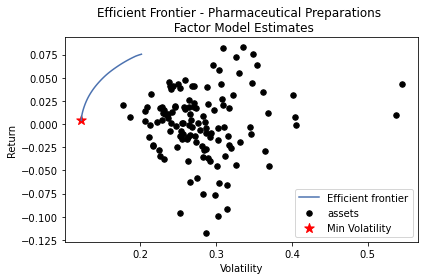

In [25]:
ef1 = EfficientFrontier(mu_Pharm, cov_Factor_Model, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_Pharm, cov_Factor_Model, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - Pharmaceutical Preparations \n Factor Model Estimates")
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Returns_Pharmaceutical_Preparations.png', dpi=200, bbox_inches='tight')
plt.show()

##### Min Volatility Portfolio

###### Performance

In [26]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 0.4%
Annual volatility: 12.2%
Sharpe Ratio: -0.13


###### Weights

In [27]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_factor_model_Pharmaceutical_Preparations.csv", index = False)

In [28]:
pd.read_csv("data/min_vol_factor_model_Pharmaceutical_Preparations.csv")

,Company_Name,Weight
0,XOMA CORP,0.04907
1,ANI PHARMACEUTICALS INC,0.05767
2,"FORTRESS BIOTECH, INC.",0.00223
3,"PACIRA PHARMACEUTICALS, INC.",0.02880
4,ZOETIS INC.,0.15867
5,FLEXION THERAPEUTICS INC,0.06494
6,NATURES SUNSHINE PRODUCTS INC,0.12507
7,BIOSPECIFICS TECHNOLOGIES CORP,0.01813
8,"LEXICON PHARMACEUTICALS, INC.",0.04470
9,JOHNSON & JOHNSON,0.10600


### Results for the Other 4 Industries

In [29]:
SIC_list = [7372, 1311, 6798, 6022]
SIC_desc = ['Prepackaged Software (mass reproduction of software)', 'Crude Petroleum and Natural Gas', 
           'Real Estate Investment Trusts', 'State Commercial Banks (commercial banking)']

#### Prepackaged Software (mass reproduction of software)

In [30]:
SIC = SIC_list[0]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

r = r_selected.T[LIST].T

coef_mat = pd.DataFrame(0, index = r.columns, columns = range(n_components))

LR = LinearRegression()
for i in range(len(r.columns)):
    date = r.columns[i]
    r_t_i = r[date] 
    reg = LR.fit(B_matrix, r_t_i)
    coef_mat.iloc[i] = reg.coef_

prediction = B_matrix.dot(coef_mat.T)
residual = r - prediction

mu_sample = mu[LIST]

cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + np.diag(np.diag(residual.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index

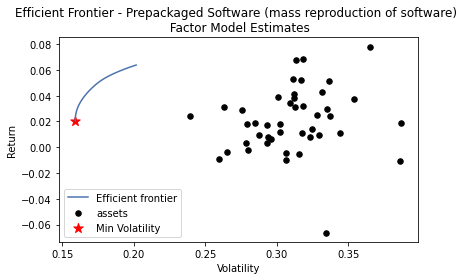

In [31]:
# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Factor Model Estimates" %industry_name)
ax.legend()
plt.tight_layout()
#plt.savefig('images/Efficient_Frontier_Factor_Model_Estimates_Prepackaged_Software.png', dpi=200, bbox_inches='tight')
#plt.show()

![Efficient_Frontier_Factor_Model_Estimates_Prepackaged_Software.png](images/Efficient_Frontier_Factor_Model_Estimates_Prepackaged_Software.png)

##### Min Volatility Portfolio

###### Performance

In [32]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 2.1%
Annual volatility: 15.9%
Sharpe Ratio: 0.00


###### Weights

In [33]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_factor_model_Prepackaged_Software.csv", index = False)

In [34]:
pd.read_csv("data/min_vol_factor_model_Prepackaged_Software.csv")

,Company_Name,Weight
0,"2U, INC.",0.17282
1,VEEVA SYSTEMS INC,0.00393
2,NATIONAL INSTRUMENTS CORP,0.02857
3,TABLEAU SOFTWARE INC,0.05614
4,3D SYSTEMS CORP,0.02612
5,INTELLIGENT SYSTEMS CORP,0.02224
6,QUMU CORP,0.04725
7,REALPAGE INC,0.02637
8,"ENDURANCE INTERNATIONAL GROUP HOLDINGS, INC.",0.11228
9,MICROSTRATEGY INC,0.12752


#### Crude Petroleum and Natural Gas
When we conduct the same analysis, there is no weight shown. Efficient frontier cannot be found.

In [35]:
SIC = SIC_list[1]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

mu_sample = mu[LIST]
# get the outliers
outlier = mu_sample[mu_sample>1].index
mu_sample = mu_sample.drop(outlier)
LIST = mu_sample.index

B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

r = r_selected.T[LIST].T

coef_mat = pd.DataFrame(0, index = r.columns, columns = range(n_components))

LR = LinearRegression()

for i in range(len(r.columns)):
    date = r.columns[i]
    r_t_i = r[date] 
    reg = LR.fit(B_matrix, r_t_i)
    coef_mat.iloc[i] = reg.coef_

prediction = B_matrix.dot(coef_mat.T)
residual = r - prediction

cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + np.diag(np.diag(residual.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index

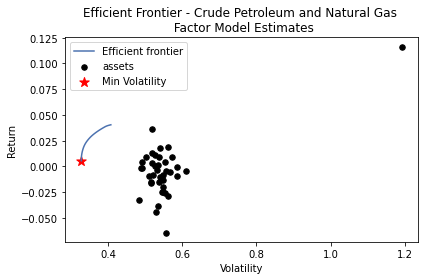

In [36]:
# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Factor Model Estimates" %industry_name)
ax.legend()
plt.tight_layout()
#plt.savefig('images/Efficient_Frontier_Factor_Model_Estimates_Crude_Petroleum_and_Natural_Gas.png', dpi=200, bbox_inches='tight')
#plt.show()

![Efficient_Frontier_Factor_Model_Estimates_Crude_Petroleum_and_Natural_Gas.png](images/Efficient_Frontier_Factor_Model_Estimates_Crude_Petroleum_and_Natural_Gas.png)

##### Min Volatility Portfolio

###### Performance

In [37]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 0.6%
Annual volatility: 32.8%
Sharpe Ratio: -0.04


###### Weights

In [38]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_factor_model_Crude_Petroleum_and_Natural_Gas.csv", index = False)

In [39]:
pd.read_csv("data/min_vol_factor_model_Crude_Petroleum_and_Natural_Gas.csv")

,Company_Name,Weight
0,GULFPORT ENERGY CORP,0.01520
1,CONTANGO OIL & GAS CO,0.04268
2,CONCHO RESOURCES INC,0.04303
3,CALIFORNIA RESOURCES CORP,0.13625
4,KOSMOS ENERGY LTD.,0.12827
5,MATADOR RESOURCES CO,0.00083
6,ANTERO RESOURCES CORP,0.07803
7,"WPX ENERGY, INC.",0.03656
8,ABRAXAS PETROLEUM CORP,0.03174
9,"DORCHESTER MINERALS, L.P.",0.03139


#### Real Estate Investment Trusts

In [40]:
SIC = SIC_list[2]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

mu_sample = mu[LIST]
# get the outliers
outlier = mu_sample[mu_sample>1].index
mu_sample = mu_sample.drop(outlier)
LIST = mu_sample.index

B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

r = r_selected.T[LIST].T

coef_mat = pd.DataFrame(0, index = r.columns, columns = range(n_components))

LR = LinearRegression()

for i in range(len(r.columns)):
    date = r.columns[i]
    r_t_i = r[date] 
    reg = LR.fit(B_matrix, r_t_i)
    coef_mat.iloc[i] = reg.coef_

prediction = B_matrix.dot(coef_mat.T)
residual = r - prediction

cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + np.diag(np.diag(residual.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index

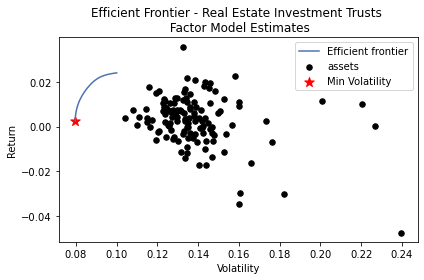

In [41]:
# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Factor Model Estimates" %industry_name)
ax.legend()
plt.tight_layout()
#plt.savefig('images/Efficient_Frontier_Factor_Model_Estimates_Real_Estate_Investment_Trusts.png', dpi=200, bbox_inches='tight')
plt.show()

![Efficient_Frontier_Factor_Model_Estimates_Real_Estate_Investment_Trusts.png](images/Efficient_Frontier_Factor_Model_Estimates_Real_Estate_Investment_Trusts.png)

##### Min Volatility Portfolio

###### Performance

In [42]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 0.3%
Annual volatility: 8.0%
Sharpe Ratio: -0.22


###### Weights

In [43]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_factor_model_Real_Estate_Investment_Trusts.csv", index = False)

In [44]:
pd.read_csv("data/min_vol_factor_model_Real_Estate_Investment_Trusts.csv")

,Company_Name,Weight
0,VORNADO REALTY TRUST,0.01771
1,EQUITY COMMONWEALTH,0.04242
2,CUBESMART,0.01261
3,"RYMAN HOSPITALITY PROPERTIES, INC.",0.01746
4,NATIONAL STORAGE AFFILIATES TRUST,0.03862
5,EQUITY RESIDENTIAL,0.12677
6,KILROY REALTY CORP,0.07864
7,"COLONY NORTHSTAR, INC.",0.00385
8,CYRUSONE INC.,0.08523
9,LTC PROPERTIES INC,0.04618


#### State Commercial Banks (commercial banking)

In [45]:
SIC = SIC_list[3]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

r = r_selected.T[LIST].T

coef_mat = pd.DataFrame(0, index = r.columns, columns = range(n_components))

In [46]:
LR = LinearRegression()

In [47]:
for i in range(len(r.columns)):
    date = r.columns[i]
    r_t_i = r[date] 
    reg = LR.fit(B_matrix, r_t_i)
    coef_mat.iloc[i] = reg.coef_

prediction = B_matrix.dot(coef_mat.T)
residual = r - prediction

mu_sample = mu[LIST]

cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + np.diag(np.diag(residual.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index

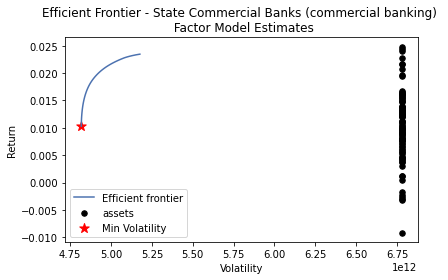

In [48]:
# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))


fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Factor Model Estimates" %industry_name)
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Factor_Model_Estimates_State_Commercial_Banks.png', dpi=200, bbox_inches='tight')
plt.show()

![Efficient_Frontier_Factor_Model_Estimates_State_Commercial_Banks.png](images/Efficient_Frontier_Factor_Model_Estimates_State_Commercial_Banks.png)

##### Min Volatility Portfolio

###### Performance

In [49]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 1.0%
Annual volatility: 481810558319191.8%
Sharpe Ratio: -0.00


###### Weights

In [50]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_factor_model_State_Commercial_Banks.csv", index = False)

In [51]:
pd.read_csv("data/min_vol_factor_model_State_Commercial_Banks.csv")

,Company_Name,Weight
0,COMMUNITY FINANCIAL CORP /MD/,0.01064
1,FIRST FINANCIAL CORP /IN/,0.01064
2,SVB FINANCIAL GROUP,0.01064
3,NORWOOD FINANCIAL CORP,0.01064
4,MACATAWA BANK CORP,0.01064
...,...,...
89,WESTERN ALLIANCE BANCORPORATION,0.01064
90,"GERMAN AMERICAN BANCORP, INC.",0.01064
91,CHEMICAL FINANCIAL CORP,0.01064
92,STEWARDSHIP FINANCIAL CORP,0.01064
